<a href="https://colab.research.google.com/github/SrishtiTyagii/coursework/blob/main/heart_disease_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'heart-disease-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F216167%2F477177%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240909%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240909T082605Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D8ec7427559e2612087a60fafeb086df37ae51fa4faabd030a3571b20c224d8f8500c4c1f8e7b6bd35fc2aca7a6d818d7669d94fa76380f0840a4e2d77370bdfdc4b1558817d0dd9a600d33faeb85a5236a2da584abfb1d064af05134d50a6fcc96ce16b96db0fcb599f26b5a6b48ab59277794966279c1e5a95035e226330e88ad8c4cc434c7b50bb337e006fa1fd09905bd2533bc8981e315e7e9a77c8611cef4f25a4d6564b6a73aa7e8ce124c02a35446a10ad836c2cd1d3a881cdb27c82937fe72123d5e3dcbc4e90e4ef48060f7fe2b4ea889683725555dbb8297431659505050351fcc8beadf0f4bc8f72f52df2b3886c3748036fd537d783f72228488'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 6325 bytes downloaded
Downloaded and uncompressed: heart-disease-dataset
Data source import complete.


# 1. Library Imports

In [3]:
# Importing Basic Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random as rd
import warnings
import plotly.express as px
import plotly.io as pio
warnings.filterwarnings('ignore')

# Importing Machine Learning Library
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import RandomOverSampler

* Data Manipulation (pandas, numpy)
* Visualization (matplotlib, seaborn, plotly)
* Machine Learning (scikit-learn, imblearn)
* Suppressing Warnings (warnings)

# 2. Loading Dataset

In [4]:
df=pd.read_csv('/kaggle/input/heart-disease-dataset/heart.csv')

* Loads the heart disease dataset into a pandas DataFrame.

# 3. Dataset Shape

In [5]:
df.shape

(1025, 14)

* This displays the shape of the dataset.
> Rows: 1,025 samples
> Columns: 14 features
* Helps verify the size of the dataset.

# 4. Displaying Data Head

In [6]:
df.head(10)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0
5,58,0,0,100,248,0,0,122,0,1.0,1,0,2,1
6,58,1,0,114,318,0,2,140,0,4.4,0,3,1,0
7,55,1,0,160,289,0,0,145,1,0.8,1,1,3,0
8,46,1,0,120,249,0,0,144,0,0.8,2,0,3,0
9,54,1,0,122,286,0,0,116,1,3.2,1,2,2,0


*  Displays the first five rows of the dataset, showing information like age, sex, blood pressure, cholesterol, and target class (whether the patient has heart disease).

# 5. Checking Missing Values

In [7]:
df.isnull().sum()

,0
age,0
sex,0
cp,0
trestbps,0
chol,0
fbs,0
restecg,0
thalach,0
exang,0
oldpeak,0


* This checks for any missing values in the dataset.
* No missing values are found in any of the columns.


# 6. Data Types

In [8]:
df.dtypes

,0
age,int64
sex,int64
cp,int64
trestbps,int64
chol,int64
fbs,int64
restecg,int64
thalach,int64
exang,int64
oldpeak,float64


* Displays the data types of each column.
* Most of the columns are int64, except for oldpeak, which is float64.
* This helps understand the structure of the dataset and ensures the data types are suitable for analysis.

# 7. Data Exploration, Cleaning, and Preprocessing

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1025.0,54.434146,9.072290,29.0,48.0,56.0,61.0,77.0
sex,1025.0,0.695610,0.460373,0.0,0.0,1.0,1.0,1.0
cp,1025.0,0.942439,1.029641,0.0,0.0,1.0,2.0,3.0
trestbps,1025.0,131.611707,17.516718,94.0,120.0,130.0,140.0,200.0
chol,1025.0,246.000000,51.592510,126.0,211.0,240.0,275.0,564.0
fbs,1025.0,0.149268,0.356527,0.0,0.0,0.0,0.0,1.0
restecg,1025.0,0.529756,0.527878,0.0,0.0,1.0,1.0,2.0
thalach,1025.0,149.114146,23.005724,71.0,132.0,152.0,166.0,202.0
exang,1025.0,0.336585,0.472772,0.0,0.0,0.0,1.0,1.0
oldpeak,1025.0,1.071512,1.175053,0.0,0.0,0.8,1.8,6.2


* Provides summary statistics for all numerical columns in the dataset. The describe() function by default includes statistics such as:

>1. count: Number of non-null values
>2. mean: Average of the values
>3. std: Standard deviation (measure of spread)
>4. min: Minimum value
>5. 25%, 50%, 75%: Percentile values (25th percentile, median, and 75th percentile)
>6. max: Maximum value

* Adding .T transposes the result, which makes it easier to read by flipping the rows and columns. After transposing, each column name will be displayed as a row, and the statistics will be columns.
* Helps in understanding the distribution, spread, and basic properties of the dataset before moving on to analysis or cleaning.



In [10]:
df.duplicated().sum()

723

* This checks for duplicate rows in the dataset.

* duplicated(): Identifies rows that have identical values across all columns when compared to another row.
* sum(): Summing the results returns the total number of duplicated rows.
* This is important for ensuring data quality, as duplicate rows could bias the model's performance or lead to incorrect conclusions.

* Helps identify redundant data that needs to be removed to avoid skewing the analysis.

In [11]:
df.drop_duplicates(inplace=True)

* This removes any duplicate rows from the dataset.

* drop_duplicates(): Finds and drops any duplicated rows based on all columns by default.
* inplace=True: Ensures that the changes are made directly to the existing DataFrame instead of creating a copy.
* After detecting duplicates using the previous command, this step actually removes them to ensure that the dataset contains only unique records.



In [12]:
df.duplicated().sum()

0

* This checks again for duplicate rows after running df.drop_duplicates().

* The output is 0, confirming that all duplicate entries have been successfully removed.
* Verifies that the duplicate removal process was successful and the dataset is clean.

In [13]:
df.nunique()

,0
age,41
sex,2
cp,4
trestbps,49
chol,152
fbs,2
restecg,3
thalach,91
exang,2
oldpeak,40


* This calculates the number of unique values for each column in the DataFrame.

* nunique(): Returns a count of distinct values in each column, which helps in understanding the variability within the dataset.
* This is useful for identifying categorical columns or checking for columns with very few unique values (which might be less useful for prediction).

* This step is part of understanding the distribution and uniqueness of the data, which is important for feature engineering.



In [14]:
df.rename(columns={
    'age' : 'Age',
    'sex' : 'Sex',
    'cp' : 'Chest Pain',
    'trestbps':'Resting_BP',
    'chol':'Cholestrol',
    'fbs':'Fasting_Blood_Sugar',
    'restecg':'Resting ECG',
    'thalach':'Max_Heart_rate',
    'exang':'Excercies_Induced_Angina',
    'oldpeak':'Old_Peak',
    'ca':'No_Major_Vessels',
    'thal':'Thal',
    'target':'Target'},inplace=True)

* This renames the columns of the dataset for better readability and understanding.

* The new names are more descriptive and easier to understand compared to the original abbreviations (e.g., age becomes Age, cp becomes Chest Pain, etc.).
* inplace=True: Ensures the changes are applied directly to the original DataFrame without needing to reassign it.



In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 302 entries, 0 to 878
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       302 non-null    int64  
 1   Sex                       302 non-null    int64  
 2   Chest Pain                302 non-null    int64  
 3   Resting_BP                302 non-null    int64  
 4   Cholestrol                302 non-null    int64  
 5   Fasting_Blood_Sugar       302 non-null    int64  
 6   Resting ECG               302 non-null    int64  
 7   Max_Heart_rate            302 non-null    int64  
 8   Excercies_Induced_Angina  302 non-null    int64  
 9   Old_Peak                  302 non-null    float64
 10  slope                     302 non-null    int64  
 11  No_Major_Vessels          302 non-null    int64  
 12  Thal                      302 non-null    int64  
 13  Target                    302 non-null    int64  
dtypes: float64(1), 

* This provides a concise summary of the DataFrame.

* It includes information about:
>1. Number of entries (rows) and columns.
>2. Data types of each column (e.g., int64, float64, object).
>3. The number of non-null (non-missing) values in each column.
* This function is useful for quickly checking the data types and verifying if there are any missing values.

In [16]:
df_copy=df.copy()

* This creates a copy of the DataFrame df and assigns it to df_copy.

* Creating a copy allows the analyst to experiment with modifications without affecting the original dataset. This is a safeguard in case I need to revert to the unmodified data.

In [17]:
df_copy.replace({'Sex':{0:'Female',1:'Male'}},inplace=True)

* This replaces the numerical values in the Sex column with more descriptive categorical labels.

>1. 0 is replaced with 'Female'.
>2. 1 is replaced with 'Male'.
* The replace() function is used to map these numerical codes to more readable labels.

* inplace=True ensures that the replacements are applied directly to df_copy without needing to reassign it.
* This step is part of data transformation to make categorical variables clearer for analysis and visualizations.

In [18]:
df_copy.replace({'Target':{0:'Clean',1:'Disease '}},inplace=True)

* This is similar to the previous step but applied to the Target column, where:

>1. 0 is replaced with 'Clean' (no heart disease).
>2. 1 is replaced with 'Disease' (indicating the presence of heart disease).
* Like the Sex column, this makes the Target column easier to understand by converting numeric codes into descriptive labels.



In [19]:
corr_matrix=df.corr()
corr_matrix

,Age,Sex,Chest Pain,Resting_BP,Cholestrol,Fasting_Blood_Sugar,Resting ECG,Max_Heart_rate,Excercies_Induced_Angina,Old_Peak,slope,No_Major_Vessels,Thal,Target
Age,1.000000,-0.094962,-0.063107,0.283121,0.207216,0.119492,-0.111590,-0.395235,0.093216,0.206040,-0.164124,0.302261,0.065317,-0.221476
Sex,-0.094962,1.000000,-0.051740,-0.057647,-0.195571,0.046022,-0.060351,-0.046439,0.143460,0.098322,-0.032990,0.113060,0.211452,-0.283609
Chest Pain,-0.063107,-0.051740,1.000000,0.046486,-0.072682,0.096018,0.041561,0.293367,-0.392937,-0.146692,0.116854,-0.195356,-0.160370,0.432080
Resting_BP,0.283121,-0.057647,0.046486,1.000000,0.125256,0.178125,-0.115367,-0.048023,0.068526,0.194600,-0.122873,0.099248,0.062870,-0.146269
Cholestrol,0.207216,-0.195571,-0.072682,0.125256,1.000000,0.011428,-0.147602,-0.005308,0.064099,0.050086,0.000417,0.086878,0.096810,-0.081437
Fasting_Blood_Sugar,0.119492,0.046022,0.096018,0.178125,0.011428,1.000000,-0.083081,-0.007169,0.024729,0.004514,-0.058654,0.144935,-0.032752,-0.026826
Resting ECG,-0.111590,-0.060351,0.041561,-0.115367,-0.147602,-0.083081,1.000000,0.041210,-0.068807,-0.056251,0.090402,-0.083112,-0.010473,0.134874
Max_Heart_rate,-0.395235,-0.046439,0.293367,-0.048023,-0.005308,-0.007169,0.041210,1.000000,-0.377411,-0.342201,0.384754,-0.228311,-0.094910,0.419955
Excercies_Induced_Angina,0.093216,0.143460,-0.392937,0.068526,0.064099,0.024729,-0.068807,-0.377411,1.000000,0.286766,-0.256106,0.125377,0.205826,-0.435601
Old_Peak,0.206040,0.098322,-0.146692,0.194600,0.050086,0.004514,-0.056251,-0.342201,0.286766,1.000000,-0.576314,0.236560,0.209090,-0.429146


* This computes the correlation matrix for the DataFrame.

* corr(): Calculates the pairwise Pearson correlation coefficients between all numerical columns in the dataset.
* The correlation coefficient ranges between -1 and 1:
>1. 1 indicates a perfect positive linear relationship.
>2. -1 indicates a perfect negative linear relationship.
>3. 0 indicates no linear relationship.
* The correlation matrix helps identify relationships between features. It is especially useful for understanding which features are strongly correlated with the target variable (heart disease) and with each other.

In [20]:
target_corr = corr_matrix['Target'].sort_values(ascending=False)
print("Correlation with target:\n", target_corr)

Correlation with target:
 Target                      1.000000
Chest Pain                  0.432080
Max_Heart_rate              0.419955
slope                       0.343940
Resting ECG                 0.134874
Fasting_Blood_Sugar        -0.026826
Cholestrol                 -0.081437
Resting_BP                 -0.146269
Age                        -0.221476
Sex                        -0.283609
Thal                       -0.343101
No_Major_Vessels           -0.408992
Old_Peak                   -0.429146
Excercies_Induced_Angina   -0.435601
Name: Target, dtype: float64


* This extracts the correlations between the Target (heart disease indicator) and all other features.

* corr_matrix['Target']: Retrieves the column of correlations between the target variable (Target) and all other features.
* sort_values(ascending=False): Sorts the correlation values in descending order so that features most positively correlated with the target are listed first.
* This step helps in identifying which features have the strongest relationships with the target variable.


# 8. Data Visualization: Correlation Matrix Heatmap

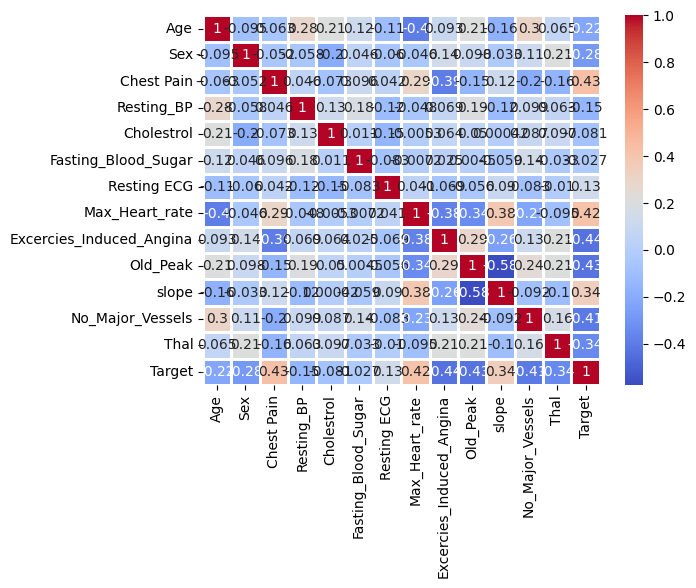

In [21]:
sns.heatmap(corr_matrix,annot=True,linewidths=2,cmap='coolwarm')
plt.show()

* The heatmap provides a visual representation of the correlation matrix, where:

> Red indicates a positive correlation (closer to +1).

> Blue indicates a negative correlation (closer to -1).

> White or neutral colors indicate correlations close to 0 (little to no linear relationship).

* By using this heatmap, I can easily spot strong correlations (positive or negative) between features and the target variable, as well as between different features.
* High positive correlation (e.g., close to 1) between the target variable and certain features suggests that those features are strong predictors.
* High negative correlation (e.g., close to -1) suggests a strong inverse relationship.
* Weak correlations (closer to 0) indicate little to no linear relationship between the features.








# 9. Data Visualization: Countplot

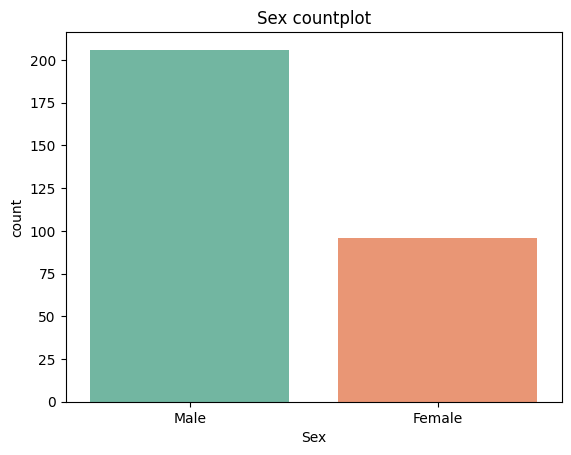

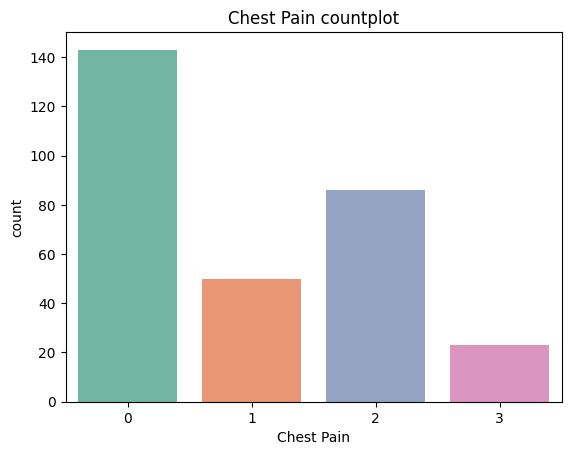

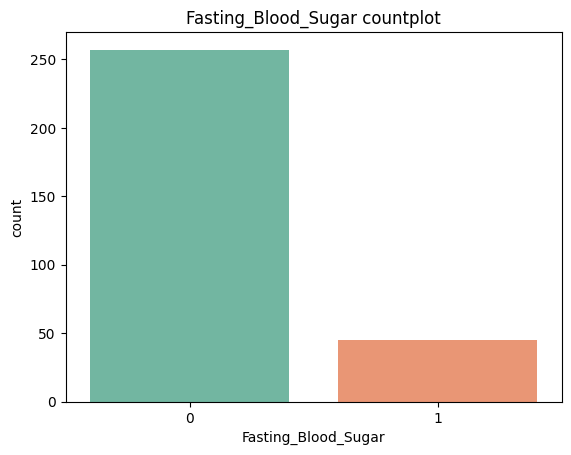

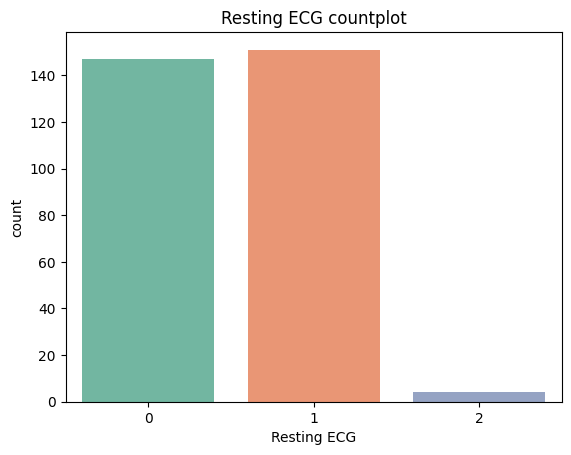

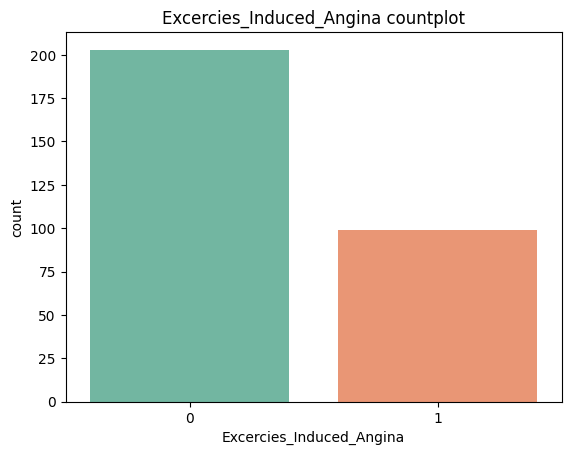

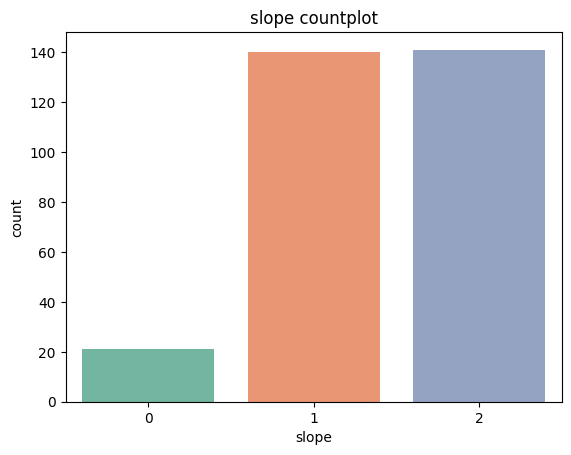

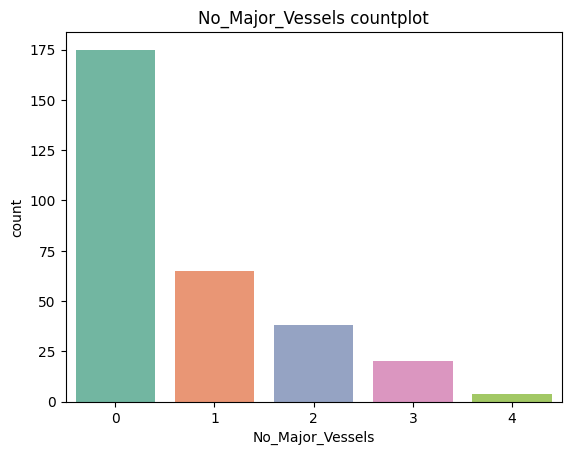

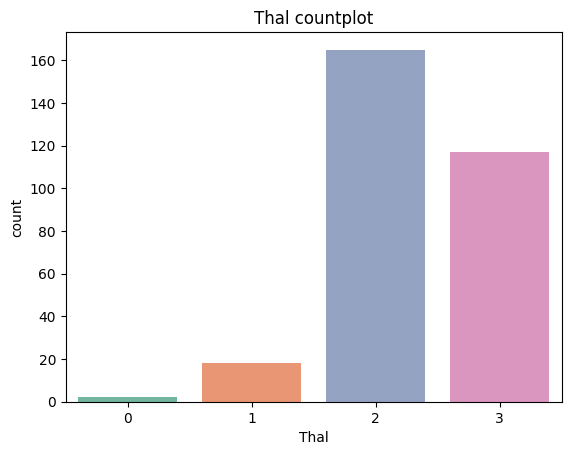

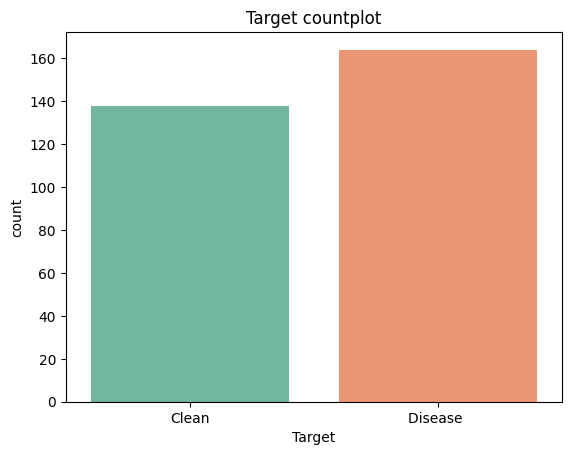

In [22]:
cols_to_plot=['Sex','Chest Pain','Fasting_Blood_Sugar','Resting ECG',
              'Excercies_Induced_Angina','slope','No_Major_Vessels','Thal','Target']
for col in cols_to_plot:
    sns.countplot(data=df_copy,x=col, palette='Set2')
    plt.title(f'{col} countplot')
    plt.show()

* Count plots provide a visual representation of the distribution of categorical features. This helps to:

> Understand feature distribution: Visualizing how each category (e.g., Male/Female in Sex) is distributed in the dataset.

> Identify class imbalance: For features like Target (disease presence/absence), count plots reveal if the data is imbalanced, which might require handling through techniques like oversampling or undersampling.

> Check feature relationships: While these plots show counts, later analysis might show how these features relate to the target variable.

* This is part of the exploratory data analysis (EDA) and helps identify potential issues, such as class imbalance, or trends that could be useful for modeling.

# 10. Data Visualization: Pie chart

In [23]:
px.pie(df_copy,values='Age', names = 'Sex',title='Age Vs Sex')

* Each slice represents a sex category, and the size of each slice corresponds to the 'Age' values.

In [24]:
px.pie(df_copy,values='Age', names = 'Target',title='Age Vs Target')

* The pie chart display slices sized according to 'Age', with each slice labeled based on the 'Target' column.

# 11. Data Visualization: Box Plot

In [25]:
fig=px.box(df, y='Resting_BP', title='Resting_BP Box Plot ',orientation='v')
fig.update_traces(marker_color='green', boxmean='sd')

In [26]:
fig2=px.box(df, y='Cholestrol', title='Cholestrol Box Plot ',orientation='v')
fig2.update_traces(marker_color='blue', boxmean='sd')

In [27]:
fig3=px.box(df, y='Max_Heart_rate', title='Max_Heart_rate Box Plot ',orientation='v')
fig3.update_traces(marker_color='black', boxmean='sd')

In [28]:
fig4=px.box(df, y='Old_Peak', title='Old_Peak Box Plot ',orientation='v')
fig4.update_traces(marker_color='purple', boxmean='sd')

In [29]:
fig5=px.box(df, y='No_Major_Vessels', title='No_Major_Vessels Box Plot ',orientation='v')
fig5.update_traces(marker_color='gray', boxmean='sd')

# 12. Data Visualization: Histogram

In [30]:
hist_fig= px.histogram(df_copy, x='Age', title='Agewise Distribution')
hist_fig.update_traces(marker_color='green', opacity=0.7)

In [31]:
hist_fig2= px.histogram(df_copy, x='Resting_BP', title='Resting_BP Distribution')
hist_fig2.update_traces(marker_color='blue', opacity=0.7)

In [32]:
hist_fig3= px.histogram(df_copy, x='Cholestrol', title='Cholestrol Distribution')
hist_fig3.update_traces(marker_color='black', opacity=0.7)

In [33]:
hist_fig4= px.histogram(df_copy, x='Max_Heart_rate', title='Max_Heart_rate Distribution')
hist_fig4.update_traces(marker_color='purple', opacity=0.7)

In [34]:
hist_fig5= px.histogram(df_copy, x='Old_Peak', title='Old_Peak Distribution')
hist_fig5.update_traces(marker_color='gray', opacity=0.7)

# 13. Data Preparation

In [35]:
y=df[['Target']]
x=df.drop('Target',axis=1)

* Separates the dataset into feature variables (x) and the target variable (y)

In [36]:
x

,Age,Sex,Chest Pain,Resting_BP,Cholestrol,Fasting_Blood_Sugar,Resting ECG,Max_Heart_rate,Excercies_Induced_Angina,Old_Peak,slope,No_Major_Vessels,Thal
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
723,68,0,2,120,211,0,0,115,0,1.5,1,0,2
733,44,0,2,108,141,0,1,175,0,0.6,1,0,2
739,52,1,0,128,255,0,1,161,1,0.0,2,1,3
843,59,1,3,160,273,0,0,125,0,0.0,2,0,2


In [37]:
y

,Target
0,0
1,0
2,0
3,0
4,0
...,...
723,1
733,1
739,0
843,0


# 14. Feature Selection

In [38]:
cols_to_drop=['Fasting_Blood_Sugar','Cholestrol','Resting_BP','Resting ECG','Age']
df.drop(cols_to_drop,axis=1,inplace=True)

* Removes specified columns from the dataset, which is done to eliminate irrelevant, redundant, or unneeded features before training a machine learning model.

# 15. Import train_test_split and split data

In [39]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=272)

* Imports the train_test_split function from the sklearn.model_selection module, which is used to split a dataset into training and testing sets.
* Splits the features (x) and target variable (y) into training and testing sets. The test_size=0.2 parameter specifies that 20% of the data should be used for testing, and the random_state=272 parameter ensures that the split is reproducible by setting a seed for the random number generator.

In [40]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(241, 13)
(61, 13)
(241, 1)
(61, 1)


* These lines print the shapes of the training and testing feature sets (x_train and x_test) and the training and testing target sets (y_train and y_test).
* This helps verify the size of each subset after the split.

# 16. Logistic Regression Model

In [41]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

* This code initializes a logistic regression model, trains it on the training data, and then uses it to predict the target variable for the testing data.

# 17. Confusion Matrix

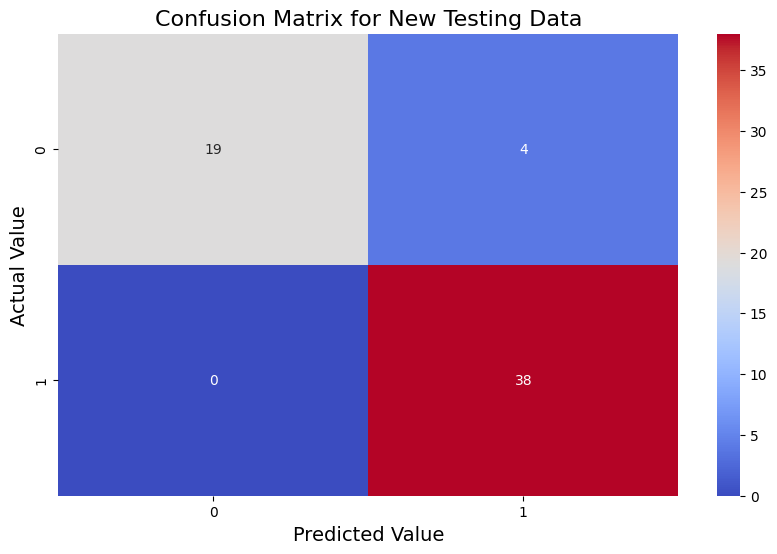

In [42]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,6))
plt.title('Confusion Matrix for New Testing Data', fontsize=16)
sns.heatmap(cm, annot=True, fmt='g', cmap='coolwarm')
plt.xlabel('Predicted Value', fontsize=14)
plt.ylabel('Actual Value', fontsize=14)
plt.show()

* The confusion matrix is a table that shows the number of correct and incorrect predictions, organized by the actual and predicted classes.
*  The code generates and displays a heatmap of the confusion matrix, which visualizes the performance of a classification model by showing the counts of true and false positives and negatives.

In [43]:
accuracy_score(y_test, y_pred)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.83      0.90        23
           1       0.90      1.00      0.95        38

    accuracy                           0.93        61
   macro avg       0.95      0.91      0.93        61
weighted avg       0.94      0.93      0.93        61



* For Class 0:

> Precision: 1.00 – All predicted class 0 instances are correct.

> Recall: 0.83 – The model correctly identified 83% of actual class 0 instances.

> F1-Score: 0.90 – The harmonic mean of precision and recall, indicating a good balance between the two metrics.

> Support: 23 – The number of actual instances of class 0 in the test set.

* For Class 1:

> Precision: 0.90 – 90% of predicted class 1 instances are correct.

> Recall: 1.00 – The model correctly identified 100% of actual class 1 instances.

> F1-Score: 0.95 – The harmonic mean of precision and recall, showing excellent performance for class 1.

> Support: 38 – The number of actual instances of class 1 in the test set.
Overall Metrics:

* Accuracy: 0.93 – The model correctly predicted the class for 93% of the instances in the test set.

* Macro Average:

> Precision: 0.95 – The average precision across classes, treating all classes equally.

> Recall: 0.91 – The average recall across classes.

> F1-Score: 0.93 – The average F1-score across classes.

* Weighted Average:

> Precision: 0.94 – The precision averaged across classes, weighted by the number of instances in each class.

> Recall: 0.93 – The recall averaged across classes, weighted by the number of instances in each class.

> F1-Score: 0.93 – The F1-score averaged across classes, weighted by the number of instances in each class.

* The model performs well overall with an accuracy of 93%. It excels in correctly identifying instances of class 1 with a perfect recall and a high F1-score. Class 0 has slightly lower recall but still maintains a high precision and F1-score. The macro and weighted averages reflect strong performance across all metrics.

In [44]:
model = LogisticRegression(max_iter=10000)
model.fit(x_train, y_train)
y_probs = model.predict_proba(x_test)[:, 1]

* The code initializes a logistic regression model, trains it on the training data, and then predicts the probabilities of the positive class (class 1) for the test data.

# 18. ROC Curve and AUC Score

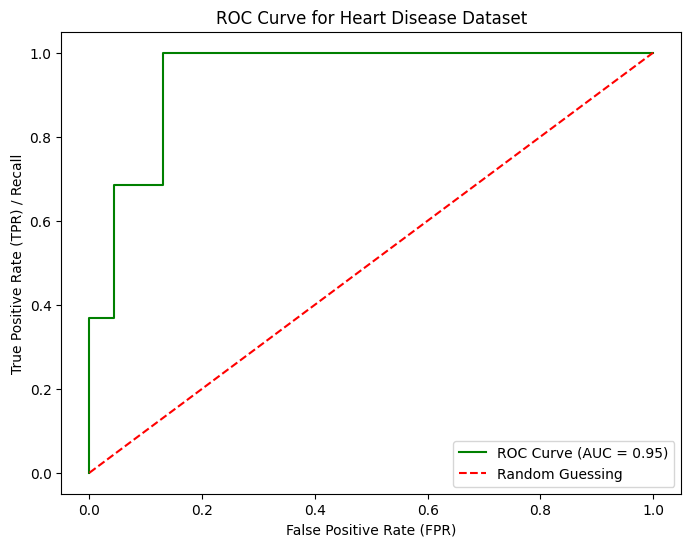

In [45]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# calculates the Area Under the ROC Curve (AUC)
auc_score = roc_auc_score(y_test, y_probs)

# Plot the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})', color='green')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing', color='red')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR) / Recall')
plt.title('ROC Curve for Heart Disease Dataset')
plt.legend()
plt.show()

* ROC Curve is a graphical representation of a model’s performance at various classification thresholds. It helps visualize the trade-off between the True Positive Rate (Recall) and False Positive Rate.
* AUC Score summarizes the overall ability of the model to discriminate between positive and negative classes. A higher AUC indicates better performance.

* AUC (Area Under the Curve) ranges from 0 to 1:

> 1.0: Perfect classification.

> 0.5: Random guessing (no predictive ability).

> Below 0.5: Worse than random guessing.

* AUC = 0.95 indicates that the model has a very high level of discrimination, meaning it correctly classifies 95% of the instances on average. It is highly effective at distinguishing between the positive class (e.g., presence of heart disease) and the negative class (e.g., absence of heart disease).

***The closer the ROC curve is to the top-left corner, the better the model performs.
The curve shows how well the model balances sensitivity (True Positive Rate) and specificity (False Positive Rate) across different thresholds.***